In [1]:
import numpy as np

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Spheres

In [165]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)

In [166]:
def proto_err_fast(Xa,Xb,Xatest,Xbtest,idxs_a,idxs_b):
    ''' Performs a quick heuristic m-shot learning experiment on a pair of manifolds X=(Xa,Xb),
    allowing overlap between training and test examples.
    
    Args: 
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    # Prototypes
    xabar = Xa[idxs_a].mean(0)
    xbbar = Xb[idxs_b].mean(0)

    # Distances to prototypes
    daa = ((Xatest[:,None] - xabar[None])**2).sum(-1)
    dab = ((Xatest[:,None] - xbbar[None])**2).sum(-1)
    dba = ((Xbtest[:,None] - xabar[None])**2).sum(-1)
    dbb = ((Xbtest[:,None] - xbbar[None])**2).sum(-1)
    ha = -daa + dab
    hb = -dbb + dba

    erra = (ha<0).mean()
    errb = (hb<0).mean()

    return erra, errb


def NN_err_fast(Xa,Xb,Xatest,Xbtest,idxs_a,idxs_b):
    ''' Performs a quick heuristic NN learning experiment on a pair of manifolds X=(Xa,Xb),
    allowing overlap between training and test examples.
    
    Args: 
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    
    # Prototypes
    xabar = Xa[idxs_a]
    xbbar = Xb[idxs_b]

    # Distances to prototypes
    daa = ((Xatest[:,None,None] - xabar[None])**2).sum(-1)
    dab = ((Xatest[:,None,None] - xbbar[None])**2).sum(-1)
    dba = ((Xbtest[:,None,None] - xabar[None])**2).sum(-1)
    dbb = ((Xbtest[:,None,None] - xbbar[None])**2).sum(-1)
    ha = -daa.min(1) + dab.min(1)
    hb = -dbb.min(1) + dba.min(1)

    erra = (ha<0).mean()
    errb = (hb<0).mean()

    return erra, errb

In [255]:
P = 100
N = 500
m = 10
dx0 = 1/2
ntest = 100

def sphere_experiment(m,N):
#     U = np.random.randn(2*N+1,2*N+1)
#     U,_ = np.linalg.qr(U)
#     Ua = U[:N]
#     Ub = U[N:2*N]
#     mu = U[-1]

    mu = np.random.randn(N)
    mu /= np.linalg.norm(mu)

    s = np.random.randn(P,N) / np.sqrt(N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatrain = mu*dx0/2 + s
    
    s = np.random.randn(P,N) / np.sqrt(N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatest = mu*dx0/2 + s
    
    s = np.random.randn(P,N) / np.sqrt(N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtrain = -mu*dx0/2 + s
    
    s = np.random.randn(P,N) / np.sqrt(N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtest = -mu*dx0/2 + s
    
    idxs_a = np.random.randint(0,P,(m,int(ntest)))
    idxs_b = np.random.randint(0,P,(m,int(ntest)))
    
    NNerr_a, NNerr_b = NN_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
    proto_err_a, proto_err_b = proto_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
    
    return (proto_err_a+proto_err_b)/2, (NNerr_a + NNerr_b)/2

In [256]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,10)
ms = np.linspace(2,200,20,dtype='int')
n_avg = 1
for m in tqdm(ms):
    for N in tqdm(Ns,leave=False):
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

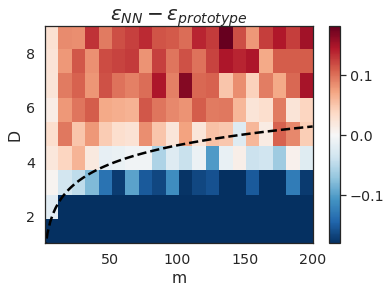

In [257]:
with sns.axes_style('white'):
    diff = (-proto_errs + NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmin=-vmax/3,vmax=vmax/3)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

## Vary dimensionality

In [302]:
P = 100
N = 101
m = 10
dx0 = 1
ntest = 100

def sphere_experiment_orthogonal(m,D):
#     D = N//2-1
    U = np.random.randn(N,2*D+1)
#     U /= np.linalg.norm(U,axis=0)
    U,_ = np.linalg.qr(U)
    
    Ua,Ub,x0 = np.split(U,(D,2*D),axis=1)
#     x0 /= 10

    sa = np.random.randn(D,P) / np.sqrt(D)
    sa /= np.linalg.norm(sa,axis=0)
    sb = np.random.randn(D,P) / np.sqrt(D)
    sb /= np.linalg.norm(sb,axis=0)
    
    Xatrain = (x0 + Ua@sa).T
    Xbtrain = (-x0 + Ub@sb).T
    
    sa = np.random.randn(D,P) / np.sqrt(D)
    sa /= np.linalg.norm(sa,axis=0)
    sb = np.random.randn(D,P) / np.sqrt(D)
    sb /= np.linalg.norm(sb,axis=0)
    
    Xatest = (x0 + Ua@sa).T
    Xbtest = (-x0 + Ub@sb).T
    
    idxs_a = np.random.randint(0,P,(m,int(ntest)))
    idxs_b = np.random.randint(0,P,(m,int(ntest)))
    
    NNerr_a, NNerr_b = NN_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
    proto_err_a, proto_err_b = proto_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
    
    return (proto_err_a+proto_err_b)/2, (NNerr_a + NNerr_b)/2

In [303]:
proto_errs = []
NN_errs = []

Ns = np.arange(4,20,5)
ms = np.linspace(2,200,20,dtype='int')
n_avg = 1
for m in tqdm(ms):
    for D in tqdm(Ns,leave=False):
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment_orthogonal(m,D)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

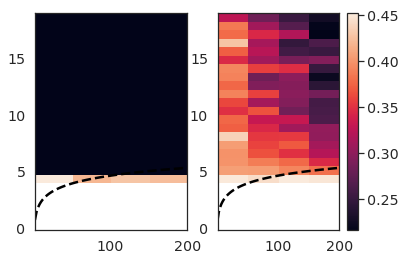

In [304]:
with sns.axes_style('white'):
    plt.subplot(121)
    diff = NN_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),aspect='auto')
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.subplot(122)
    diff = proto_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),aspect='auto')
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

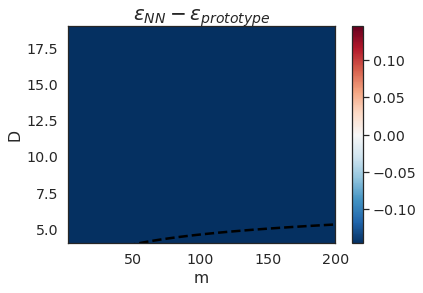

In [305]:
with sns.axes_style('white'):
    diff = (-proto_errs + NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmin=-vmax/3,vmax=vmax/3)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

# Object manifolds

In [3]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/'
manifolds_load = np.load(emb_path + 'manifolds.npy',allow_pickle=True)

In [4]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [268]:
centers = manifolds.mean(1)

In [269]:
U,S,V = np.linalg.svd(centers - centers.mean(0),full_matrices=False)

In [326]:
ntest

100

In [329]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,50,5)
ms = np.linspace(2,30,10,dtype='int')
n_avg = 1
ntest = 1000
for _ in tqdm(range(n_avg)):
    a,b = np.random.choice(1000,2,replace=False)
    Xa = manifolds[a]
    Xb = manifolds[b]
    Ua,Sa,Va = np.linalg.svd(Xa - Xa.mean(0))
    Ub,Sb,Vb = np.linalg.svd(Xb - Xb.mean(0))
    for k in tqdm(Ns,leave=False):
        A = np.random.randn(2048,k) / np.sqrt(k)
#         Xak = Xa@A
#         Xbk = Xb@A
        Xak = Ua[:,:k]*Sa[:k]@Va[:k]
#         Xak *= (Sa**2).sum() / (Sa[:k]**2).sum()
        Xak += Xa.mean(0)
        Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
#         Xbk *= (Sb**2).sum() / (Sb[:k]**2).sum()
        Xbk += Xb.mean(0)
        for m in ms:
            perma = np.random.permutation(P)
            permb = np.random.permutation(P)
            Xatrain,Xatest = np.split(Xak[perma],2)
            Xbtrain,Xbtest = np.split(Xbk[permb],2)
            
            # Generalization error
            idxs_a = np.random.randint(0,P//2,(m,int(ntest)))
            idxs_b = np.random.randint(0,P//2,(m,int(ntest)))
            NNerr_a, NNerr_b = NN_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
            proto_err_a, proto_err_b = proto_err_fast(Xatrain,Xbtrain,Xatest,Xbtest,idxs_a,idxs_b)
            
            NN_errs.append((NNerr_a + NNerr_b)/2)
            proto_errs.append((proto_err_a + proto_err_b)/2)
proto_errs = np.stack(proto_errs).reshape(n_avg,len(Ns),len(ms)).mean(0)
NN_errs = np.stack(NN_errs).reshape(n_avg,len(Ns),len(ms)).mean(0)

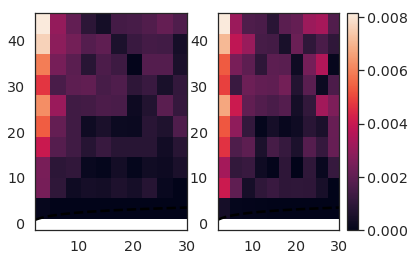

In [327]:
with sns.axes_style('white'):
    plt.subplot(121)
    diff = NN_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),aspect='auto')
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.subplot(122)
    diff = proto_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),aspect='auto')
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

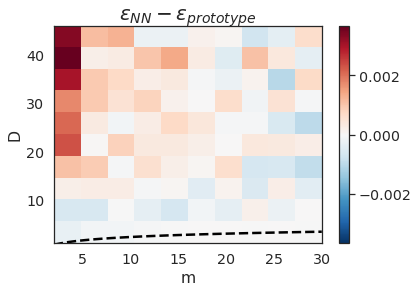

In [328]:
with sns.axes_style('white'):
    diff = -proto_errs + NN_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmin=-vmax,vmax=vmax)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

In [26]:
m = 5
perma = np.random.permutation(P)
permb = np.random.permutation(P)
Xatrain,Xatest = np.split(Xa[perma],(m,))
Xbtrain,_ = np.split(Xb[permb],(m,))

In [ ]:
w = Xatrain.mean(0) - Xbtrain.mean(0)
mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
h = Xatest@w - w@mu
proto_err = (h<0).mean()

ytrain = np.concatenate([np.ones(m),-np.ones(m)])
Xtrain = np.vstack([Xatrain,Xbtrain])
nn.fit(Xtrain,ytrain)
yhat = nn.predict(Xatest)
NN_err = (yhat!=1).mean()